In [321]:
#install.packages("readxl")
library(tidyverse)
library(rvest)
library(readxl)

options(repr.plot.width=15, repr.plot.height=15, repr.plot.pointsize=1000) # Setting plot size as a global option.

base_theme <- theme(plot.title=element_text(size=30), # Setting a default size for all text in our plots.
                    axis.title=element_text(size=30),
                    axis.text.x=element_text(size=15),
                    axis.text.y=element_text(size=15),
                    legend.title=element_text(size=25),
                    legend.text=element_text(size=20)) 




In [270]:
#first we get all xlsx file links from url
mental_health_data_urls_all_years <- 'https://www.health.govt.nz/our-work/mental-health-and-addiction/mental-health-and-addiction-monitoring-reporting-and-data' %>% 
                                        read_html() %>%
                                        html_element('#node-12245 > div > div > div > ul:nth-child(19)') %>%
                                        html_elements("a") %>%
                                        html_attrs() %>% 
                                        str_c('https://www.health.govt.nz/', .)

#function is to download xlsx from health url 
download_xlsx_file <- function(heath_url, file_name){
                        download_ur <- heath_url %>% 
                            read_html() %>%
                            html_element("#block-system-main > div > div:nth-child(2) > div.panel-panel.right.col-xs-12.col-sm-12.col-md-3.col-lg-3 > div.panel-pane.pane-views.pane-file-attachments-revisioning.pane-downloads-right.standard-block.even.hidden-xs.hidden-sm > div > div > div > div > ul > li > span > a") %>% 
                            html_attr("href") 
                        download.file(url = download_ur, destfile = file_name)
}


build_sheet_name <- function(str1, str2, separator){
    data <- paste(str1, str2, sep=separator)
    return(data)
}

get_sheet_separator <- function(file_name){
    sheets <- file_name %>% excel_sheets()
    if ('table1,2' %in% sheets){
        separator <- ','
    }else{
        separator <- '&'
    }
}


#iteral through every year from 2014 to 2019
file_metadata_df <- data.frame(year=double(),
                               file_name=character(),
                               url=character(),
                               separator=character())

start_year = 2014

for (url_yearly_health in mental_health_data_urls_all_years){
    file_name = str_c('mental_health', start_year) %>% 
                    str_c('.xlsx')
    start_year = start_year + 1
    print(url_yearly_health)
    download_xlsx_file(url_yearly_health, file_name)
    separator <- get_sheet_separator(file_name)
    file_metadata_df <- file_metadata_df %>% add_row(year=start_year-1,
                                                 file_name=file_name,
                                                 url=url_yearly_health,
                                                 separator=separator)
}
#we add some custom years to the list
file_metadata_df <- file_metadata_df %>% add_row(year=2011:2013, 
                                                 file_name=c('mental_health2011.xlsx', 'mental_health2012.xlsx', 'mental_health2013.xlsx'),
                                                 url=NA,
                                                 separator='&')

file_metadata_df

[1] "https://www.health.govt.nz//publication/mental-health-and-addiction-service-use-2019-20-tables"
[1] "https://www.health.govt.nz//publication/mental-health-and-addiction-service-use-2018-19-tables"
[1] "https://www.health.govt.nz//publication/mental-health-and-addiction-service-use-2017-18-tables"
[1] "https://www.health.govt.nz//publication/mental-health-and-addiction-service-use-2016-17-tables"
[1] "https://www.health.govt.nz//publication/mental-health-and-addiction-service-use-2016-17-tables"
[1] "https://www.health.govt.nz//publication/mental-health-and-addiction-service-use-2014-15"
[1] "https://www.health.govt.nz//publication/mental-health-and-addiction-service-use-2013-14"


year,file_name,url,separator
<dbl>,<chr>,<chr>,<chr>
2014,mental_health2014.xlsx,https://www.health.govt.nz//publication/mental-health-and-addiction-service-use-2019-20-tables,","
2015,mental_health2015.xlsx,https://www.health.govt.nz//publication/mental-health-and-addiction-service-use-2018-19-tables,","
2016,mental_health2016.xlsx,https://www.health.govt.nz//publication/mental-health-and-addiction-service-use-2017-18-tables,","
2017,mental_health2017.xlsx,https://www.health.govt.nz//publication/mental-health-and-addiction-service-use-2016-17-tables,","
2018,mental_health2018.xlsx,https://www.health.govt.nz//publication/mental-health-and-addiction-service-use-2016-17-tables,","
2019,mental_health2019.xlsx,https://www.health.govt.nz//publication/mental-health-and-addiction-service-use-2014-15,&
2020,mental_health2020.xlsx,https://www.health.govt.nz//publication/mental-health-and-addiction-service-use-2013-14,&
2011,mental_health2011.xlsx,NA,&
2012,mental_health2012.xlsx,NA,&


In [291]:
#get all col names for table use after
#get metadata from one of the files.
first_file = file_metadata_df[1,]

age_group_col_names <-  first_file$file_name %>% read_excel(sheet = build_sheet_name('table1', '2', first_file$separator),
                                                            range = cell_rows(4:4)) %>% colnames()
add_sex_totl_age_group_col_names <- c('gender', "Total", age_group_col_names)


table_1_2_positions <- tibble(ethnic_group=c('Maori', 'Pacific', 'Asian', 'Other'),
                              range=c('B9:U10', 'B12:U13', 'B15:U16', 'B18:U19'))


In [292]:
#two different way get first table of total group data

clients_by_age_ethnic_group_df <- data.frame(year=double(),
                                         gender=character(), 
                                         ethnic_group=character(),
                                         age_group=character(),
                                         amount=integer() 
                                         ) 


get_clients_by_gender_ethnic_group <- function(file_metadata, columns){

    clients_by_age_ethnic_group <- data.frame(year=double(),
                                         gender=character(), 
                                         ethnic_group=character(),
                                         age_group=character(),
                                         amount=integer()) 
    
    for (i in 1:nrow(table_1_2_positions)) {
        row <- table_1_2_positions[i,]
        if (file_metadata$year == '2011'){
            sheet <- 'Table1'
        }else if(file_metadata$year == '2012'){
            sheet <- 'table1'
        }else{
            sheet <- build_sheet_name("table1", "2", file_metadata$separator)
        }
        ethnic_group_df <- file_metadata$file_name %>% read_excel(sheet=sheet,
                                                       range = row$range,
                                                       col_names = add_sex_totl_age_group_col_names) #range = cell_rows(3:19), 
        ethnic_group_df <- ethnic_group_df %>% add_column(ethnic_group=row$ethnic_group, year=file_metadata$year)
        ethnic_group_df <- ethnic_group_df %>% select(-Total)
        long_col_name <- ethnic_group_df %>% select(ends_with("-"), ends_with('+')) %>% names()
        clients_by_age_ethnic_group <- clients_by_age_ethnic_group %>% 
                                       add_row(ethnic_group_df %>% 
                                       gather(age_group, amount, long_col_name, factor_key=TRUE))
    }  
    return(clients_by_age_ethnic_group)
}

get_all_year_clients_by_gender_ethnic_group <- function(){
    for (i in 1:nrow(file_metadata_df )){
        row <- file_metadata_df[i,]
        clients_by_age_ethnic_group_df <- clients_by_age_ethnic_group_df %>% add_row(get_clients_by_gender_ethnic_group(row, add_sex_totl_age_group_col_names))
    }
    return(clients_by_age_ethnic_group_df) 
    
}



In [293]:
full_clients_by_gender_ethnic_df <- get_all_year_clients_by_gender_ethnic_group()
full_clients_by_gender_ethnic_df %>% sample_n(10)

year,gender,ethnic_group,age_group,amount
<dbl>,<chr>,<chr>,<chr>,<dbl>
2011,Female,Pacific,10-,232
2014,Male,Other,70-,1255
2020,Male,Other,40-,4491
2015,Male,Pacific,5-,334
2014,Male,Maori,40-,2135
2012,Female,Asian,45-,203
2017,Female,Pacific,10-,547
2019,Female,Asian,20-,366
2016,Female,Asian,25-,507


In [294]:
# lets get the years outside of the norm
#make all df 2002-2007 data tidy

get_df_tidy <- function(df, year_num){
    #get num of row
    n_row_age_sheeta1 <- nrow(df)
    #set all na values with activity type 
    for (row_num in 1:n_row_age_sheeta1){
        if(df$ethnic_group[[row_num]] %>% is.na()){
            df$ethnic_group[[row_num]] = df$ethnic_group[[row_num - 1]]
        }
    }
    result <- df %>% 
                filter(gender!='NA') %>% 
                gather(age_group, amount, -c(ethnic_group,gender,amount)) %>% 
                mutate('year'=year_num) 
    result <- result %>% filter(gender!='Total') %>% filter(ethnic_group!='Total')
    result <- result[,c(5,2,1,3,4)]
    return(result)
}

#get 2002/2005 data

file_metadata_2001_2007 <- tibble(year=2002:2008,
                                  sheet=c('A1', 'A1', 'A1', 'A1', '1A', '1B', 'A1'),
                                  range=c('A5:U25', 'A4:U24', 'A5:U26', 'A5:U25', 'A5:U26', 'A5:U26', 'A5:U25'),
                                  titles=c('D5:U5', 'D4:U4', 'D5:U5', 'D5:U5', 'D5:U5', 'D5:U5', 'D5:U25')
                                 )

get_2001_2007_file_df <- function(file_name, year_num){
    print(year_num)
    file_metadata <- file_metadata_2001_2007 %>% filter(year==year_num)
    #get client age group names
    client_ages_sheeta1 <- file_name %>% read_excel(sheet = file_metadata$sheet, range=file_metadata$titles) %>% colnames()
    col_names_seen_by_age_sheeta1  <- c('ethnic_group', 'gender', 'amount', client_ages_sheeta1)
    
    #get data from the file rename with names before
    client_seen_by_age_data_a1 <-  file_name %>% read_excel(sheet=file_metadata$sheet, range=file_metadata$range)
    colnames(client_seen_by_age_data_a1) <- col_names_seen_by_age_sheeta1 

    return(get_df_tidy(client_seen_by_age_data_a1, year_num))
}

get_all_a1sheet_2002_2007_df <- function(){
    
    result <- get_2001_2007_file_df('mental_health2002.xls',2002) %>% 
             rbind(get_2001_2007_file_df('mental_health2003.xls',2003)) %>% 
             rbind(get_2001_2007_file_df('mental_health2004.xls',2004)) %>% 
             rbind(get_2001_2007_file_df('mental_health2005.xls',2005)) %>% 
             rbind(get_2001_2007_file_df('mental_health2006.xls',2006)) %>% 
             rbind(get_2001_2007_file_df('mental_health2007.xls',2007)) %>% 
             rbind(get_2001_2007_file_df('mental_health2008.xls',2008)) 


    return(result)
}

full_clients_by_gender_ethnic_df <- full_clients_by_gender_ethnic_df %>% 
                                    rbind(get_all_a1sheet_2002_2007_df()) %>% 
                                    arrange(year) %>% 
                                    filter(gender!='Total') %>%
                                    filter(ethnic_group!='Total')

 
nrow(full_clients_by_gender_ethnic_df)

[1] 2002


New names:
* `` -> ...1
* `` -> ...2



[1] 2003


New names:
* `` -> ...1
* `` -> ...2



[1] 2004


New names:
* `` -> ...1
* `` -> ...2



[1] 2005


New names:
* `` -> ...1
* `` -> ...2



[1] 2006


New names:
* `` -> ...1
* `` -> ...2



[1] 2007


New names:
* `` -> ...1
* `` -> ...2



[1] 2008


New names:
* `` -> ...1
* `` -> ...2



[1] 2448

In [253]:
#full_clients_by_gender_ethnic_df <- full_clients_by_gender_ethnic_df %>% rbind(get_2001_2007_file_df('mental_health2006.xls',2006))

[1] 2006


New names:
* `` -> ...1
* `` -> ...2



In [330]:
#lets clean this dataframe a little
#full_clients_by_gender_ethnic_df <- full_clients_by_gender_ethnic_df %>% mutate(ethnic_group=gsub("Māori", "Maori", ethnic_group))
#full_clients_by_gender_ethnic_df %>% filter(year=='2003') %>% 
 #                                    group_by(year, ethnic_group) %>% 
 #                                    select(year, ethnic_group, amount) %>%
 #                                    summarise(sum_amount = round(sum(amount)), .groups='drop_last')

start <- c("0-5","5-9","10-14","15-19","20-24","25-29","30-34","35-39","40-44","45-49","50-54","55-59","60-64","65-69","70-74","75-79","80-84")
end <- c("5-","10-","15-","20-","25-","30-","35-","40-","45-","50-","55-","60-","65-","70-","75-","80-","85+")
age_group_tibble <- tibble(start=start, end=end)
replace_age_group <- function(value){
    print(value)
  replace <- age_group_tibble %>% filter(start==value)
    print(replace)
  if (nrows(replace) == 0){
    return(replace$end)
  }
    return(value)
}

full_clients_by_gender_ethnic_df %>% mutate(age_group=trimws(age_group)) %>% 
                                     mutate(age_group=replace_age_group(age_group))%>% 
                                     select(age_group) %>% distinct(age_group)




   [1] "0-5"   "0-5"   "0-5"   "0-5"   "0-5"   "0-5"   "0-5"   "0-5"   "5-9"  
  [10] "5-9"   "5-9"   "5-9"   "5-9"   "5-9"   "5-9"   "5-9"   "10-14" "10-14"
  [19] "10-14" "10-14" "10-14" "10-14" "10-14" "10-14" "15-19" "15-19" "15-19"
  [28] "15-19" "15-19" "15-19" "15-19" "15-19" "20-24" "20-24" "20-24" "20-24"
  [37] "20-24" "20-24" "20-24" "20-24" "25-29" "25-29" "25-29" "25-29" "25-29"
  [46] "25-29" "25-29" "25-29" "30-34" "30-34" "30-34" "30-34" "30-34" "30-34"
  [55] "30-34" "30-34" "35-39" "35-39" "35-39" "35-39" "35-39" "35-39" "35-39"
  [64] "35-39" "40-44" "40-44" "40-44" "40-44" "40-44" "40-44" "40-44" "40-44"
  [73] "45-49" "45-49" "45-49" "45-49" "45-49" "45-49" "45-49" "45-49" "50-54"
  [82] "50-54" "50-54" "50-54" "50-54" "50-54" "50-54" "50-54" "55-59" "55-59"
  [91] "55-59" "55-59" "55-59" "55-59" "55-59" "55-59" "60-64" "60-64" "60-64"
 [100] "60-64" "60-64" "60-64" "60-64" "60-64" "65-69" "65-69" "65-69" "65-69"
 [109] "65-69" "65-69" "65-69" "65-69" "70-74" "70-7

ERROR: Error: Problem with `mutate()` column `age_group`.
[34mℹ[39m `age_group = replace_age_group(age_group)`.
[31m✖[39m Problem with `filter()` input `..1`.
[34mℹ[39m Input `..1` is `start == value`.
[31m✖[39m Input `..1` must be of size 17 or 1, not size 2448.


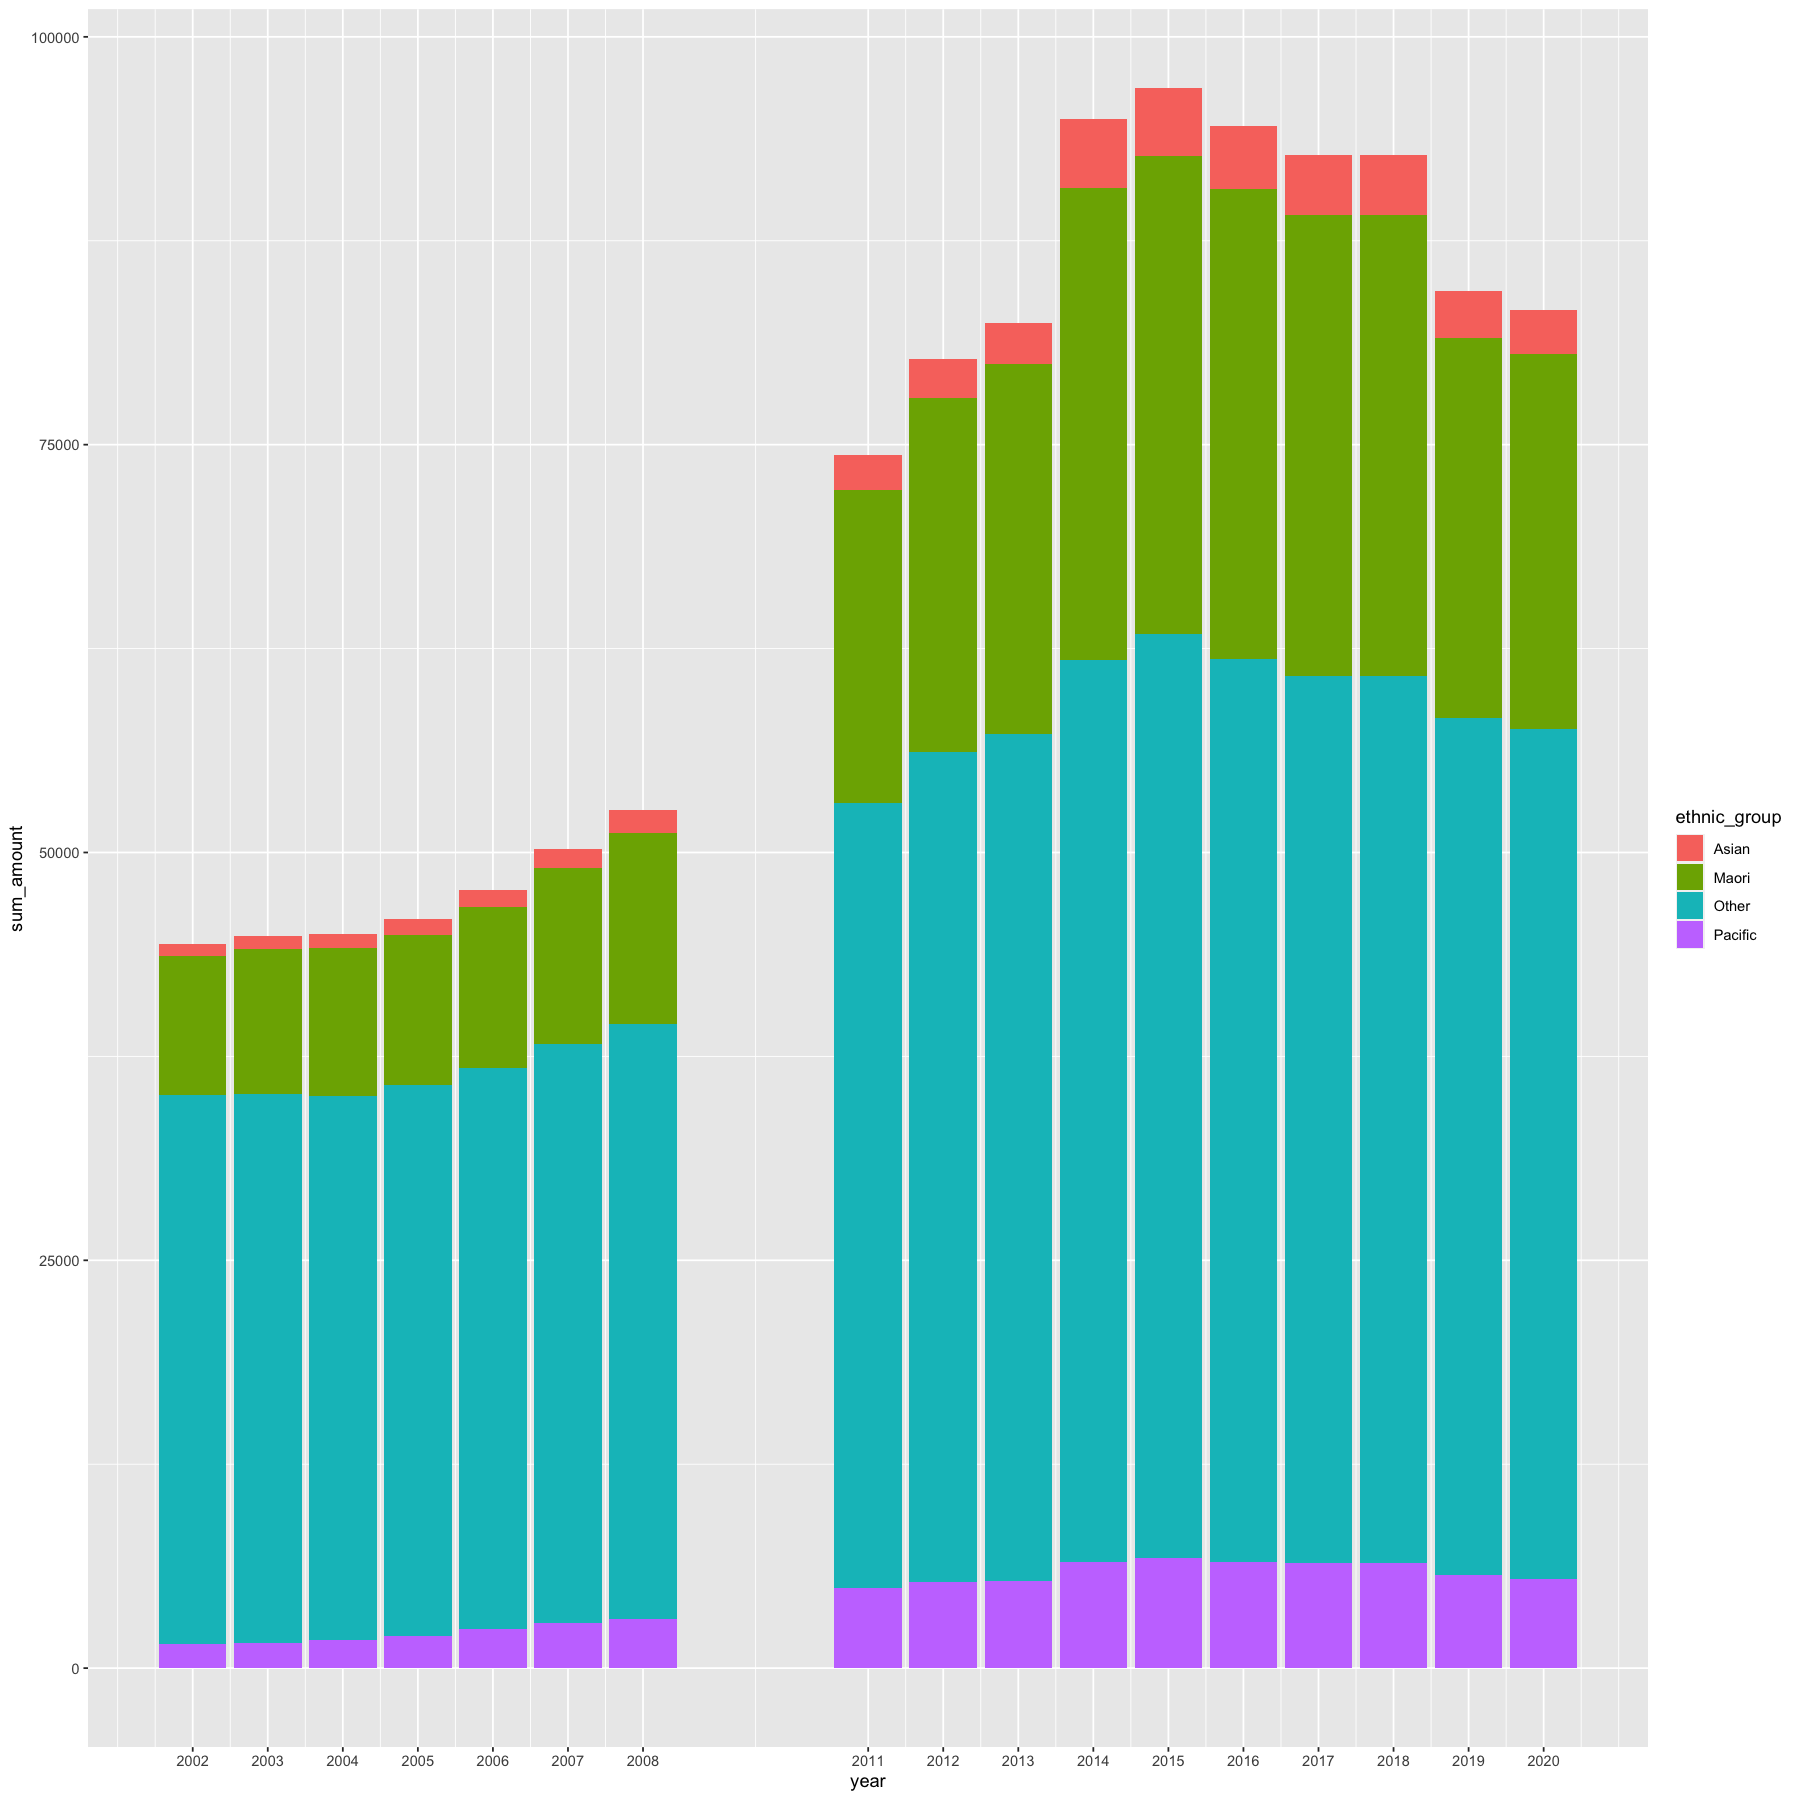

In [309]:
years <- full_clients_by_gender_ethnic_df %>% select(year) %>% distinct()
full_clients_by_gender_ethnic_df %>% filter(gender=='Male') %>%
                                     group_by(year, ethnic_group) %>% 
                                     select(year, ethnic_group, amount) %>%
                                     summarise(sum_amount = round(sum(amount)), .groups='drop_last') %>%  # getting the mean amount of users for each user type by hour (droping the last column)
                                     ggplot( aes(fill=ethnic_group, y=sum_amount, x=year)) + 
                                     geom_bar(position="stack", stat="identity") + 
                                     scale_x_continuous(breaks=years$year)

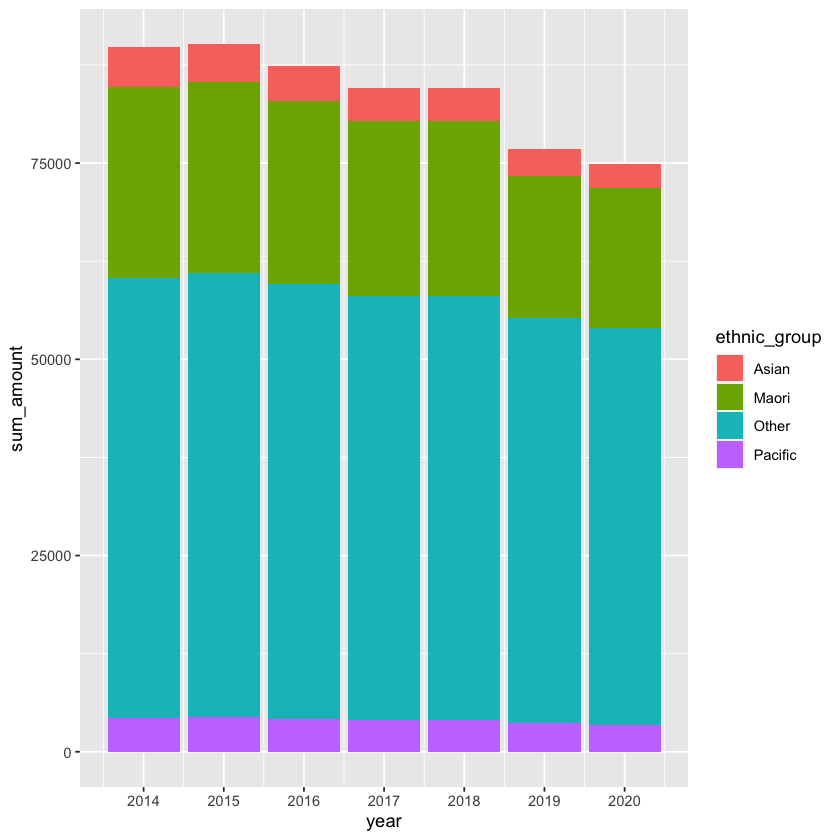

In [10]:
full_clients_by_gender_ethnic_df %>% filter(gender=='Female') %>%
                                     group_by(year, ethnic_group) %>% 
                                     select(year, ethnic_group, amount) %>%
                                     summarise(sum_amount = round(sum(amount)), .groups='drop_last') %>%  # getting the mean amount of users for each user type by hour (droping the last column)
                                     ggplot( aes(fill=ethnic_group, y=sum_amount, x=year)) + 
                                     geom_bar(position="stack", stat="identity") + 
                                     scale_x_continuous(breaks=years$year)

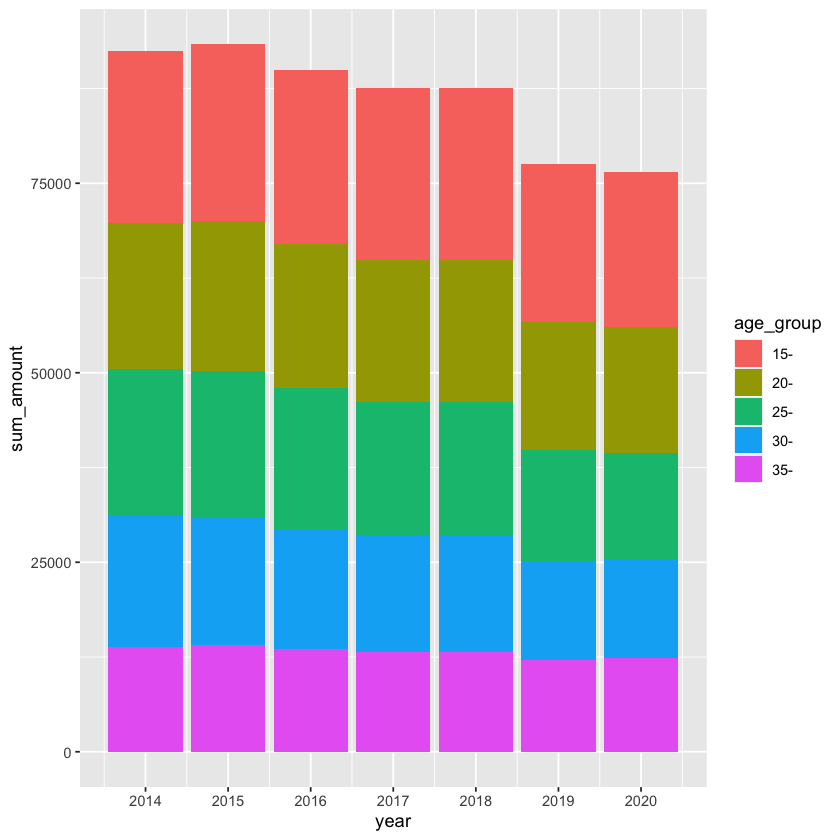

In [11]:
full_clients_by_gender_ethnic_df %>% filter(age_group %in% c('15-', '20-','25-', '30-', '35-')) %>%
                                     group_by(year, age_group) %>% 
                                     select(year, age_group, amount) %>%
                                     summarise(sum_amount = round(sum(amount)), .groups='drop_last') %>%  # getting the mean amount of users for each user type by hour (droping the last column)
                                     ggplot( aes(fill=age_group, y=sum_amount, x=year)) + 
                                     geom_bar(position="stack", stat="identity") + 
                                     scale_x_continuous(breaks=years$year)

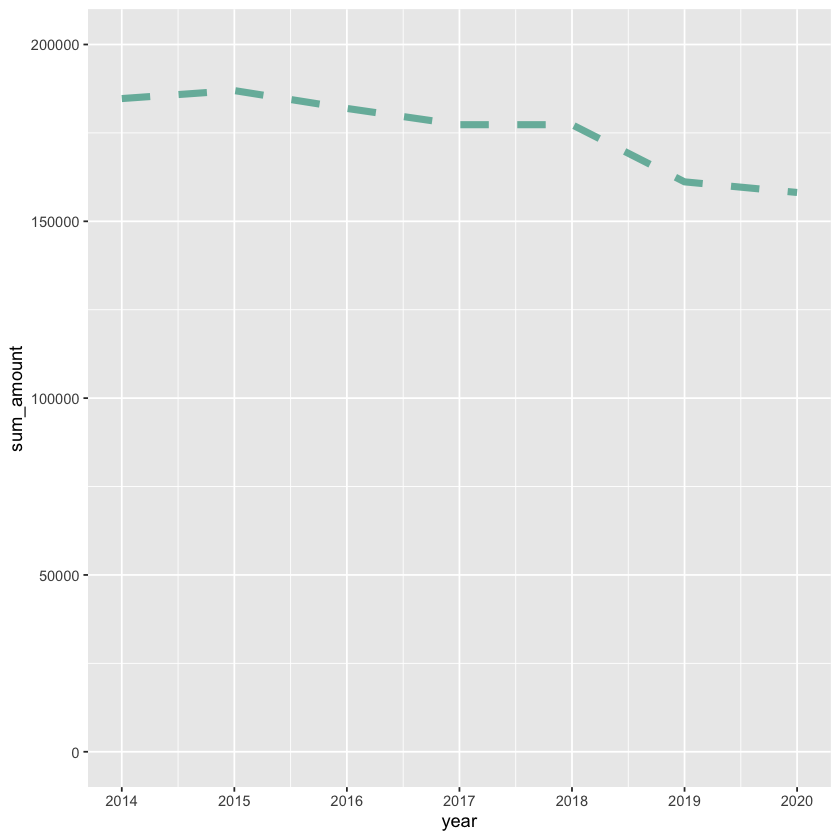

In [11]:
full_clients_by_gender_ethnic_df %>% group_by(year) %>% 
                                     select(year, amount) %>%
                                     summarise(sum_amount = sum(amount))  %>%
                                     ggplot(aes(x=year, y=sum_amount)) +
                                     scale_x_continuous(breaks=years$year) + 
                                     scale_y_continuous(limits=c(0, 200000)) + 
                                     geom_line(color="#69b3a2", size=2, alpha=0.9, linetype=2)


In [79]:
first_file = file_metadata_df[1,]

address_col_names <- first_file$file_name %>% read_excel(sheet = "table12", skip=2, range = cell_rows(4:4)) %>% colnames()
address_col_names <- address_col_names %>% prepend('city')

clients_by_address_full <- data.frame(year=double(),
                                      city=character(), 
                                      origin=character(),
                                      amount=double()) 
get_clients_by_address <- function(file_metadata, columns){

    clients_by_address <- data.frame(year=double(),
                                      city=character(), 
                                      origin=character(),
                                      amount=double()) 

    client_add_df <- file_metadata$file_name %>% read_excel(sheet = "table12", skip=2, range='A5:W26')
    colnames(client_add_df) <- columns 
    client_add_df <- client_add_df %>% select(-'Unique\r\nTotal') %>% filter(city!='')


    long_col_name <- colnames(client_add_df %>% select(-city))
    client_add_df <- client_add_df %>% gather(key='origin', value='amount',long_col_name) %>% add_column(year=file_metadata$year)
    return(client_add_df)
}

get_all_year_clients_location <- function(){
    for (i in 1:nrow(file_metadata_df)){
        row <- file_metadata_df[i,]
        clients_by_address_full <- clients_by_address_full %>% add_row(get_clients_by_address(row, address_col_names))
    }
    return(clients_by_address_full) 
}

get_all_year_clients_location() 


New names:
* `7` -> `7...9`
* `10` -> `10...10`
* `13` -> `13...11`
* `13` -> `13...12`
* `8` -> `8...13`
* ...

New names:
* `9` -> `9...11`
* `14` -> `14...14`
* `2` -> `2...16`
* `9` -> `9...17`
* `2` -> `2...18`
* ...

New names:
* `18` -> `18...7`
* `12` -> `12...10`
* `6` -> `6...11`
* `12` -> `12...12`
* `6` -> `6...13`
* ...

New names:
* `2` -> `2...16`
* `2` -> `2...20`

New names:
* `2` -> `2...16`
* `2` -> `2...20`

New names:
* `` -> ...1
* `` -> ...2
* `` -> ...3
* `` -> ...4
* `` -> ...5
* ...

New names:
* `` -> ...1
* `` -> ...2
* `` -> ...3
* `` -> ...4
* `` -> ...5
* ...



year,city,origin,amount
<dbl>,<chr>,<chr>,<dbl>
2014,Waitematā,Northland,705
2014,Auckland,Northland,218
2014,Counties Manukau,Northland,146
2014,Waikato,Northland,81
2014,Lakes,Northland,11
2014,Bay of Plenty,Northland,27
2014,Tairāwhiti,Northland,0
2014,Taranaki,Northland,13
2014,Hawkes Bay,Northland,20


data sheet 17

In [64]:
#get data from sheet 17 from one file with year num
get_data_from_sheet17 <- function(file_yealy, year){
    
    client_ages_sheet17 <- file_yealy %>% read_excel(sheet = "table17", skip=2, range = cell_rows(4:4)) %>% colnames()
    client_Activity_names_sheet17 <- c('Activity_type', 'Sex', 'total',client_ages_sheet17)

    #get df of sheet17
    client_Activity_sheet17_df <- file_yealy %>% read_excel(sheet = "table17", skip=2, range='A4:U130')
    colnames(client_Activity_sheet17_df) <- client_Activity_names_sheet17

    #get num of row
    n_row_sheet17 <- nrow(client_Activity_sheet17_df)

    #set all na values with activity type 
    for (row_num in 1:n_row_sheet17){
        if(client_Activity_sheet17_df$Activity_type[[row_num]] %>% is.na()){
            client_Activity_sheet17_df$Activity_type[[row_num]] = client_Activity_sheet17_df$Activity_type[[row_num - 1]]
            }
    }
    
    #long formate
    client_Activity_type_df <- client_Activity_sheet17_df %>% 
                                    gather('age_group', 'num_client', -c(Activity_type,Sex,total)) %>% 
                                    arrange(Activity_type, age_group)  
    
    #set all row with year
    client_Activity_type_df_yearly <- client_Activity_type_df %>% mutate('year_num' = year)
    
    return(client_Activity_type_df_yearly)
}

#get all year sheet 17 data
get_all_year_client_Activity_type_df <- function(){
    
    result <- data.frame(Activity_type=character(),
                          Sex=character(), 
                          total=character(),
                          age_group=character(),
                        num_client=character(),
                        year_num =character()) 
    
    for (i in 1:nrow(file_metadata_df)){ 
        row <- file_metadata_df[i,]
        result <- result %>% rbind(get_data_from_sheet17(row$file_name, row$year))
    }
    return(result) 
}

get_all_year_client_Activity_type_df() %>% tail()

New names:
* `` -> ...1
* `` -> ...2
* `` -> ...3

New names:
* `` -> ...1
* `` -> ...2
* `` -> ...3

New names:
* `` -> ...1
* `` -> ...2
* `` -> ...3

New names:
* `` -> ...1
* `` -> ...2
* `` -> ...3

New names:
* `` -> ...1
* `` -> ...2
* `` -> ...3

New names:
* `` -> ...1
* `` -> ...2
* `` -> ...3

New names:
* `` -> ...1
* `` -> ...2
* `` -> ...3



Activity_type,Sex,total,age_group,num_client,year_num
<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>
Work opportunity/Employment/Vocational,Total,3386,80-,0,2020
Work opportunity/Employment/Vocational,Male,1955,80-,0,2020
Work opportunity/Employment/Vocational,Female,1431,80-,0,2020
Work opportunity/Employment/Vocational,Total,3386,85+,0,2020
Work opportunity/Employment/Vocational,Male,1955,85+,0,2020
Work opportunity/Employment/Vocational,Female,1431,85+,0,2020


data sheet 23

In [67]:
#get data from sheet23 from one file
get_data_from_sheet23 <- function(file_yealy, year){
    
    client_ages_sheet23 <- file_yealy %>% read_excel(sheet = "table23", skip=2, range = cell_rows(4:4)) %>% colnames()
    client_team_type_col_names_sheet23 <- c('Team_type', 'Sex', 'total', client_ages_sheet23)

    #get df of sheet23
    client_team_type_sheet23 <- file_yealy %>% read_excel(sheet = "table23", skip=2, range='A4:U43')
    colnames(client_team_type_sheet23) <- client_team_type_col_names_sheet23

    #get num of row
    n_row_sheet23 <- nrow(client_team_type_sheet23)

    #set all na values with activity type 
    for (row_num in 1:n_row_sheet23){
        if(client_team_type_sheet23$Team_type[[row_num]] %>% is.na()){
            client_team_type_sheet23$Team_type[[row_num]] = client_team_type_sheet23$Team_type[[row_num - 1]]
            }
    }
    
    #long formate
    client_team_type_sheet23_long <- client_team_type_sheet23 %>% 
                                    gather('age_group', 'num_client', -c(Team_type,Sex,total)) %>% 
                                    arrange(Team_type, age_group)  
    
    #set all row with year
    client_team_type_sheet23_long <- client_team_type_sheet23_long %>% mutate('year_num' = year)
    
    return(client_team_type_sheet23_long)
}

#get all year sheet 23 data
get_all_year_client_team_type_df <- function(){
    
    result <- data.frame(Team_type=character(),
                          Sex=character(), 
                          total=character(),
                          age_group=character(),
                        num_client=character(),
                        year_num =character()) 
    
    for (i in 1:nrow(file_metadata_df)){ 
        row <- file_metadata_df[i,]
        result <- result %>% rbind(get_data_from_sheet23(row$file_name, row$year))
    }
    return(result) 
}

get_all_year_client_team_type_df() %>% tail()

New names:
* `` -> ...1
* `` -> ...2
* `` -> ...3

New names:
* `` -> ...1
* `` -> ...2
* `` -> ...3

New names:
* `` -> ...1
* `` -> ...2
* `` -> ...3

New names:
* `` -> ...1
* `` -> ...2
* `` -> ...3

New names:
* `` -> ...1
* `` -> ...2
* `` -> ...3

New names:
* `` -> ...1
* `` -> ...2
* `` -> ...3

New names:
* `` -> ...1
* `` -> ...2
* `` -> ...3



Team_type,Sex,total,age_group,num_client,year_num
<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>
Specialty Team,Total,4871,80-,24,2020
Specialty Team,Male,2146,80-,12,2020
Specialty Team,Female,2725,80-,12,2020
Specialty Team,Total,4871,85+,27,2020
Specialty Team,Male,2146,85+,6,2020
Specialty Team,Female,2725,85+,21,2020
